# Feed-forward Neural Network

In [ ]:
import pandas as pd
df = pd.read_csv("creditcard.csv")

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random
import sklearn
from sklearn import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost
import imblearn
import warnings
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
warnings.filterwarnings('ignore')

In [ ]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    return (train,test)

In [ ]:
import torch
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

Split data with the input features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

input_features = ['V' + str(i) for i in range(1, 29)] + ['Time', 'Amount']
output_feature = 'Class'

X = df[input_features]
y = df[output_feature]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()

features_to_scale = ['Time', 'Amount'] if 'Time' and 'Amount' in df.columns else ['Amount']
X_train_smote[features_to_scale] = scaler.fit_transform(X_train_smote[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [ ]:
import torch
x_train = torch.FloatTensor(X_train[input_features].values)
x_test = torch.FloatTensor(X_test[input_features].values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

In [ ]:
class FraudDataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

In [ ]:
train_loader_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
test_loader_params = {'batch_size': 64,
          'num_workers': 0}

training_set = FraudDataset(x_train, y_train)
testing_set = FraudDataset(x_test, y_test)

training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_loader_params)

In [ ]:
class SimpleFraudMLP(torch.nn.Module):

        def __init__(self, input_size, hidden_size):
            super(SimpleFraudMLP, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, x):

            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)

            return output

In [ ]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cpu


In [ ]:
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

The optimizer and the training loop

In [ ]:
criterion = torch.nn.BCELoss().to(DEVICE)

In [ ]:
model.eval()

SimpleFraudMLP(
  (fc1): Linear(in_features=30, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)
    return mean_loss

evaluate_model(model,testing_generator,criterion)

0.7998435073830061

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07)

In [ ]:
n_epochs = 150
model.train()

start_time=time.time()
epochs_train_losses = []
epochs_test_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss=[]
    for x_batch, y_batch in training_generator:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    epochs_train_losses.append(np.mean(train_loss))
    print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))

    val_loss = evaluate_model(model,testing_generator,criterion)
    epochs_test_losses.append(val_loss)
    print('test loss: {}'.format(val_loss))
    print("")

training_execution_time=time.time()-start_time

Epoch 0: train loss: 0.0089937586839179
test loss: 0.005332497170624322

Epoch 1: train loss: 0.004050397195080165
test loss: 0.00517435158178193

Epoch 2: train loss: 0.0035810930369943373
test loss: 0.003128299109895654

Epoch 3: train loss: 0.0034387980245796164
test loss: 0.003123536521866988

Epoch 4: train loss: 0.0032376620058073655
test loss: 0.002837328908887708

Epoch 5: train loss: 0.0030447870656688156
test loss: 0.0031133644792477847

Epoch 6: train loss: 0.0028896565019350747
test loss: 0.0029720816513562395

Epoch 7: train loss: 0.0028880086891213764
test loss: 0.0032752909565040805

Epoch 8: train loss: 0.0027260799945609876
test loss: 0.003274039328554943

Epoch 9: train loss: 0.002622555855935408
test loss: 0.0027802591113284527

Epoch 10: train loss: 0.002595912989475819
test loss: 0.0033462840263496856

Epoch 11: train loss: 0.0025380799868947577
test loss: 0.0026613224158930767

Epoch 12: train loss: 0.002508823627645338
test loss: 0.0027336356699775447

Epoch 13: 

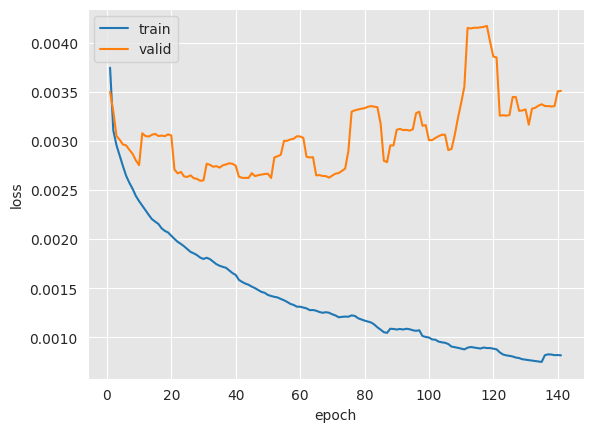

In [ ]:
ma_window = 10

plt.plot(np.arange(len(epochs_train_losses)-ma_window + 1)+1, np.convolve(epochs_train_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.plot(np.arange(len(epochs_test_losses)-ma_window + 1)+1, np.convolve(epochs_test_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])

In [ ]:
print(training_execution_time)

1602.2623150348663


In [ ]:
start_time=time.time()
predictions_test = model(x_test.to(DEVICE))
prediction_execution_time = time.time()-start_time
predictions_train = model(x_train.to(DEVICE))
print("Predictions took", prediction_execution_time,"seconds.")

Predictions took 0.9712796211242676 seconds.


In [ ]:
def performance_assessment(predictions_df, output_feature='Class',
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):

    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])

    performances = pd.DataFrame([[AUC_ROC, AP]],
                           columns=['AUC ROC','Average precision'])
    for top_k in top_k_list:

        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
    if rounded:
        performances = performances.round(3)
    return performances

def performance_assessment_model_collection(fitted_models_and_predictions_dictionary,
                                            transactions_df,
                                            type_set='test',
                                            top_k_list=[100]):
    performances=pd.DataFrame()

    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
        predictions_df=transactions_df
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        performances_model=performance_assessment(predictions_df, output_feature='Class',                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        performances=performances.append(performances_model)

    return performances

In [ ]:
!pip install my_module

  Preparing metadata (setup.py) ... done
  Created wheel for my_module: filename=my_module-1.6.2-py3-none-any.whl size=1404 sha256=f8584ba207128d337d6442f9a21e30a2e12e99797938d198c8b9e4056dbdb69c
  Stored in directory: /root/.cache/pip/wheels/ea/6f/99/8a43d4d21ab49e14293e432ea3587ec33b41e6685c86f82a88
Successfully built my_module


In [ ]:
def card_precision_top_k(predictions_df, k):
    top_k_preds = predictions_df.nlargest(k, 'predictions')
    precision_at_k = (top_k_preds['Class'] == 1).sum() / k
    recall_at_k = (top_k_preds['Class'] == 1).sum() / (predictions_df['Class'] == 1).sum()
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0
    return precision_at_k, recall_at_k, f1_at_k

In [ ]:
predictions_df = df.loc[X_test.index].copy()
predictions_df['predictions'] = predictions_test.detach().cpu().numpy()

performance_assessment(predictions_df, output_feature='Class', prediction_feature='predictions', top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.977,0.849,0.828


As the first shot, the perfomance is very decent. To prevent the overfitting, below is applied:

In [ ]:
class EarlyStopping:

    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf

    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")

        return self.counter <= self.patience

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

input_features = ['V' + str(i) for i in range(1, 29)] + ['Time', 'Amount']
output_feature = 'Class'

X = df[input_features]
y = df[output_feature]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
features_to_scale = ['Time', 'Amount'] if 'Time' in df.columns and 'Amount' in df.columns else ['Amount']
X_train_smote[features_to_scale] = scaler.fit_transform(X_train_smote[features_to_scale])
X_valid[features_to_scale] = scaler.transform(X_valid[features_to_scale])

train_df = pd.concat([X_train_smote, y_train_smote], axis=1)
valid_df = pd.concat([X_valid, y_valid], axis=1)

In [ ]:
seed_everything(SEED)

model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

def prepare_generators(train_df,valid_df,batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}

    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)

    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)

    return training_generator,valid_generator

training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

criterion = torch.nn.BCELoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005)

In [ ]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)

    all_train_losses = []
    all_valid_losses = []
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break

    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

model,training_execution_time,train_losses,valid_losses = training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=500,verbose=True)


Epoch 0: train loss: 0.31170539305703837
valid loss: 0.16926880550036721
New best score: 0.16926880550036721

Epoch 1: train loss: 0.1729170404525891
valid loss: 0.16945668663744426
1  iterations since best score.

Epoch 2: train loss: 0.17290850095140925
valid loss: 0.16959163093586727
2  iterations since best score.

Epoch 3: train loss: 0.17290392579314084
valid loss: 0.1696978681226953
3  iterations since best score.
Early stopping


In [ ]:
seed_everything(SEED)
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE) #1000 neurons
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_adam,valid_losses_adam = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=True)


Epoch 0: train loss: 0.33971431138537733
valid loss: 0.17185791651460158
New best score: 0.17185791651460158

Epoch 1: train loss: 0.17287999254455788
valid loss: 0.1718574874801087
New best score: 0.1718574874801087

Epoch 2: train loss: 0.17287981613827177
valid loss: 0.17185747017611966
New best score: 0.17185747017611966

Epoch 3: train loss: 0.17287981112949122
valid loss: 0.1718574652556759
New best score: 0.1718574652556759

Epoch 4: train loss: 0.17287980952594623
valid loss: 0.17185746372498414
New best score: 0.17185746372498414

Epoch 5: train loss: 0.17287980911949097
valid loss: 0.1718574636357782
New best score: 0.1718574636357782

Epoch 6: train loss: 0.17287980904852604
valid loss: 0.1718574635833544
New best score: 0.1718574635833544

Epoch 7: train loss: 0.17287980906066003
valid loss: 0.17185746356047302
New best score: 0.17185746356047302

Epoch 8: train loss: 0.17287980905390085
valid loss: 0.17185746354881706
New best score: 0.17185746354881706

Epoch 9: train lo

(0.16, 0.2)

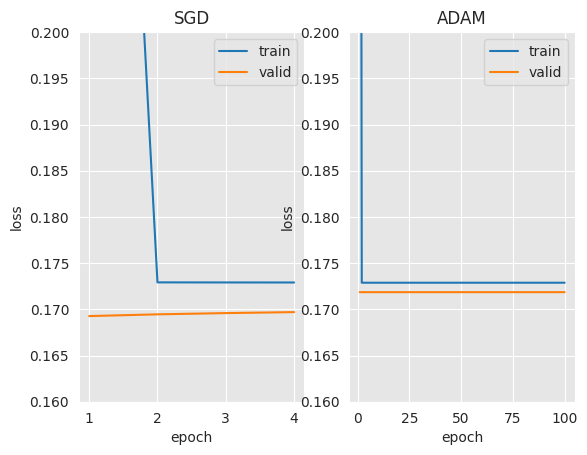

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("SGD")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.16,0.20])
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.title("ADAM")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.16,0.20])

In [ ]:
class SimpleFraudMLPWithDropout(torch.nn.Module):

        def __init__(self, input_size, hidden_size,p):
            super(SimpleFraudMLPWithDropout, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()

            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()

            self.dropout = torch.nn.Dropout(self.p)

        def forward(self, x):

            hidden = self.fc1(x)
            hidden = self.relu(hidden)

            hidden = self.dropout(hidden)

            output = self.fc2(hidden)
            output = self.sigmoid(output)

            return output

In [ ]:
seed_everything(SEED)
model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_dropout,valid_losses_dropout = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

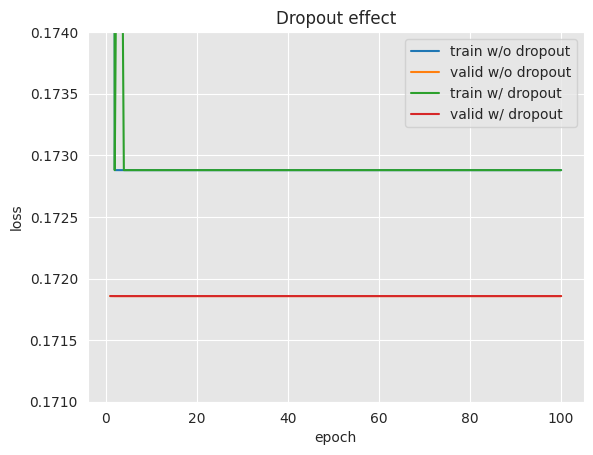

In [ ]:
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0.171,0.174])
plt.legend(['train w/o dropout','valid w/o dropout','train w/ dropout','valid w/ dropout'])

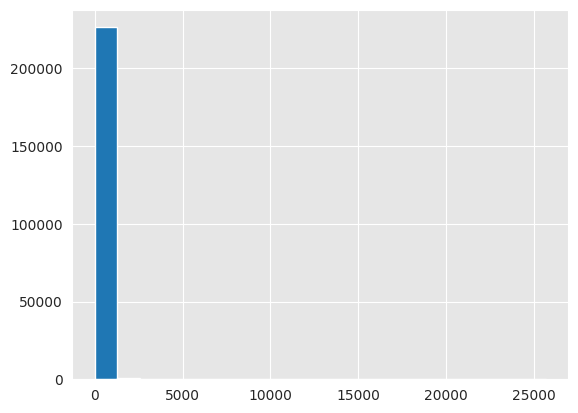

In [ ]:
_ = plt.hist(train_df['Amount'].values,bins=20)

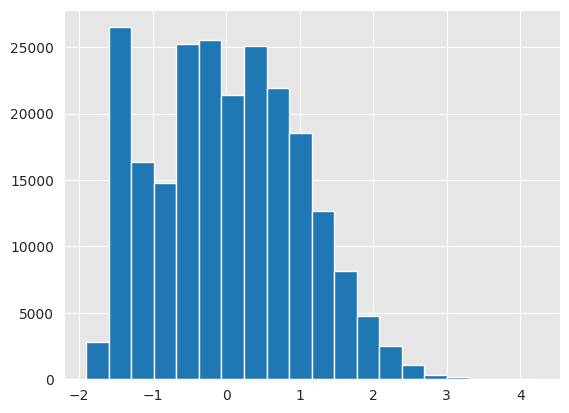

In [ ]:
_ = plt.hist(sklearn.preprocessing.StandardScaler().fit_transform(np.log1p(train_df['Amount'].values).reshape(-1, 1)),bins=20)

In [ ]:
seed_everything(SEED)
training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model,training_execution_time,train_losses_without_scaling,valid_losses_without_scaling = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

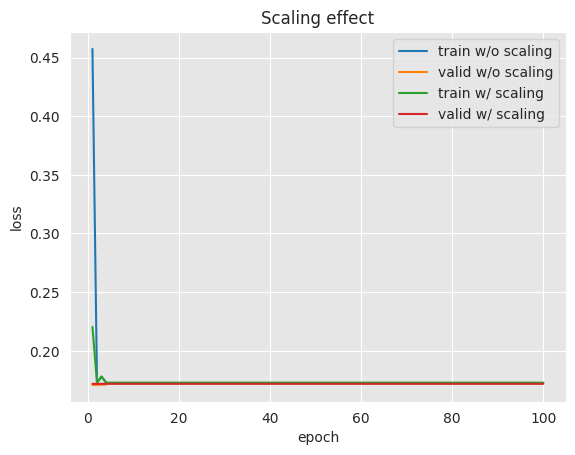

In [ ]:
plt.plot(np.arange(len(train_losses_without_scaling))+1, train_losses_without_scaling)
plt.plot(np.arange(len(valid_losses_without_scaling))+1, valid_losses_without_scaling)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title('Scaling effect')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o scaling','valid w/o scaling','train w/ scaling','valid w/ scaling'])

NN Classifier

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
from skorch import NeuralNetClassifier

In [ ]:
net = NeuralNetClassifier(
    FraudMLP,
    max_epochs=2,
    lr=0.001,
    optimizer=torch.optim.Adam,
    batch_size=64,
    dataset=FraudDatasetForPipe,
    iterator_train__shuffle=True
)
net.set_params(train_split=False, verbose=0)

<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.FraudMLP'>,
)